# 5. Machine Learning Models for TLC Prediction

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdChemReactions, rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score

## 5.1 Feature Selection and Preparation

In [48]:
def create_fingerprints(df: pd.DataFrame, column_name: str):
    """Function that creates Morgan Fingerprint, MACCS Fingerprints and RDKit Fingerprints for the extracted product molecules in the dataframe.

    Args:
        df (pd.DataFrame): dataframe containing the cleaned and extracted product SMILES
        column_name (str): column name of the SMILES column to be converted
    """
    radius = 3 # Radius of the fingerprint
    
    if column_name in ['Solvent_A_Smiles', 'Solvent_B_Smiles']:
        n_bits_morgan = 256 # shorter fingerprint for solvents
    else: 
        n_bits_morgan = 2048 # Fingerprint length for product column (more complex info needed)
        
    n_bits_rdkit = 2048
    
    
    def safe_morgan(x):
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_morgan, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_morgan, dtype=int)
        else:
            arr = np.zeros((n_bits_morgan,), dtype=int)
            morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits_morgan)
            DataStructs.ConvertToNumpyArray(morgan, arr) #wichtig, no return sondern arr wird ueberschrieben, deshalb return arr
            return arr
    
    def safe_rdkit(x):
        arr = np.zeros((2048,), dtype=int)
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_rdkit, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_rdkit, dtype=int)
        return Chem.RDKFingerprint(mol, maxPath=5, fpSize=n_bits_rdkit)
    
    def rdkit_descriptors(x):
        if x is None or not isinstance(x, str):
            return np.zeros(4)
        mol = Chem.MolFromSmiles(x)
        if mol:
            return np.array([Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                             Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol)])
        return np.zeros(4)
    
    df_new = df.copy()
    df_new[column_name + '_Morgan_Fingerprint_np'] = df[column_name].apply(safe_morgan)
    #df_new[column_name +'_RDKit_Fingerprint'] = df[column_name].apply(safe_rdkit)
    df_new[column_name + '_RDKit_Descriptors'] = df[column_name].apply(rdkit_descriptors)
    
    return df_new

In [49]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp.shape

(15063, 17)

In [50]:
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [5]:
df_fp.columns

Index(['Unnamed: 0', 'paragraphText', 'reactionSmiles', 'productSmiles',
       'title', 'Rf', 'Solvent_A', 'Solvent_B', 'Percent_A', 'Percent_B',
       'Additive_C', 'Percent_C', 'sum', 'Solvent_A_Smiles',
       'Solvent_B_Smiles', 'extracted_pr_Smiles', 'productSmiles_processed'],
      dtype='object')

In [51]:
# apply fingerprint generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# show the dataframe
df_fp.head(5)

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,Solvent_A_Smiles,Solvent_B_Smiles,extracted_pr_Smiles,productSmiles_processed,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Descriptors,Solvent_A_Smiles_Morgan_Fingerprint_np,Solvent_A_Smiles_RDKit_Descriptors,Solvent_B_Smiles_Morgan_Fingerprint_np,Solvent_B_Smiles_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,[0.3],petroleum ether (2-methylpentane),EtOAc,[50.0],[50.0],...,CCCC(C)C,O=C(OCC)C,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.442500000000001, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]"
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,[0.5],EtOAc,Hexane,[50.0],[50.0],...,O=C(OCC)C,CCCCCC,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,[0.3],EtOAc,Hexane,[70.0],[30.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,[0.4],EtOAc,Hexane,[90.0],[10.0],...,O=C(OCC)C,CCCCCC,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,[0.5],EtOAc,Hexane,[5.0],[95.0],...,O=C(OCC)C,CCCCCC,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"


In [7]:
print(type(df_fp['Percent_A'][0]))

<class 'numpy.ndarray'>


concatenate the np.arrays into larger 2D arrays for an X set (features) and a y set with the corresponding Rf values. 

In [52]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features = np.concatenate([compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features.shape, type(features), features.ndim, y.ndim, y.shape)


(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2
(15062, 2562) <class 'numpy.ndarray'> 2 2 (15062, 1)


## 5.2 FCNN Model

In [2]:
# imports for the FCNN model
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.optim as optim
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel

In [3]:
class FCNN(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        #self.linear = nn.Linear()
        self.hard_sigmoid = nn.Hardsigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.hard_sigmoid(self.fc4(x))  # Softplus to ensure positive values? hard_sigmoid: self.hard_sigmoid(self.fc4(x))
        return x

In [4]:
class FCNN_deep(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_deep, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1) # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.hard_sigmoid = nn.Hardsigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.relu(self.fc4(x)) 
        x = self.dropout_3(x)
        x = self.relu(self.fc5(x)) 
        x = self.dropout_3(x)
        x = self.hard_sigmoid(self.fc6(x)) # or no activation?
        return x

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, head_dim)

        # Einsum does matrix mult. for query*keys for each batch and each head
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, head_dim),
        # keys shape: (N, key_len, heads, head_dim)
        # energy shape: (N, heads, query_len, key_len)

        attention = torch.softmax(energy / (self.embed_size ** (0.5)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, head_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out
    
class FCNN_att(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(FCNN_att, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 128)    # Hidden layer 2
        self.fc4 = nn.Linear(128, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)

        self.self_attention = SelfAttention(embed_size=128, heads=8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)

        x = x.unsqueeze(1)  # add an extra dimension for the sequence length
        x = self.self_attention(x, x, x)  # self-attention layer
        x = x.squeeze(1)  # remove the extra dimension

        x = self.fc4(x)
        return x


In [6]:
class FCNNWithChemBERTa(nn.Module):
    def __init__(self, dropout_prob):
        super(FCNNWithChemBERTa, self).__init__()
        self.chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        self.tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        chemberta_hidden_size = self.chemberta.config.hidden_size
        self.input_size = chemberta_hidden_size * 3 + 4  # 3 ChemBerta embeddings + 4 numerical features
        
        self.fc1 = nn.Linear(self.input_size, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
    
    def forward(self, product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features):
        # Encode SMILES using ChemBERTa
        product_inputs = self.tokenizer(product_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        product_input_ids = product_inputs["input_ids"]
        product_attention_mask = product_inputs["attention_mask"]

        solvent_a_inputs = self.tokenizer(solvent_a_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        solvent_a_input_ids = solvent_a_inputs["input_ids"]
        solvent_a_attention_mask = solvent_a_inputs["attention_mask"]

        solvent_b_inputs = self.tokenizer(solvent_b_smiles, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
        solvent_b_input_ids = solvent_b_inputs["input_ids"]
        solvent_b_attention_mask = solvent_b_inputs["attention_mask"]

        product_embeddings = self.chemberta(input_ids=product_input_ids, attention_mask=product_attention_mask).last_hidden_state.mean(dim=1)
        solvent_a_embeddings = self.chemberta(input_ids=solvent_a_input_ids, attention_mask=solvent_a_attention_mask).last_hidden_state.mean(dim=1)
        solvent_b_embeddings = self.chemberta(input_ids=solvent_b_input_ids, attention_mask=solvent_b_attention_mask).last_hidden_state.mean(dim=1) # Mean pooling over tokens

        # Handle missing solvent embeddings by using zero vectors
        if solvent_a_smiles[0] == '':
            solvent_a_embeddings = torch.zeros_like(product_embeddings)
        if solvent_b_smiles[0] == '':
            solvent_b_embeddings = torch.zeros_like(product_embeddings)

        # Concatenate ChemBERTa embeddings for product and solvents
        chemberta_embeddings = torch.cat((product_embeddings, solvent_a_embeddings, solvent_b_embeddings), dim=1)
        x = torch.cat((chemberta_embeddings, numerical_features), dim=1)

        # Forward pass through FCNN layers
        x = self.relu(self.fc1(x))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.fc4(x)
        return x

### Data preprocessing

Split the dataset into training and validation set.

In [53]:
# Split the dataset into training set and temporary set using a 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(features, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets using a 50-50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### simple FCNN

Epoch 1, Train Loss: 0.03235494006229074, Val Loss: 0.03064891672693193, Train MAE: 0.14562540626839587, Val MAE: 0.13717694797863564
Epoch 2, Train Loss: 0.026465486068474618, Val Loss: 0.025184632356589038, Train MAE: 0.12983855354158502, Val MAE: 0.12384092466284831
Epoch 3, Train Loss: 0.02225078147296843, Val Loss: 0.024731977687527735, Train MAE: 0.11742772914861378, Val MAE: 0.12523104374607405
Epoch 4, Train Loss: 0.018060923191277604, Val Loss: 0.022480424493551254, Train MAE: 0.10467708291191803, Val MAE: 0.11499360265831153
Epoch 5, Train Loss: 0.015133484080433846, Val Loss: 0.021852177179728944, Train MAE: 0.09520603739901592, Val MAE: 0.11166277341544628
Epoch 6, Train Loss: 0.0133796096926457, Val Loss: 0.022229827009141445, Train MAE: 0.08935505379187433, Val MAE: 0.10968870421250661
Epoch 7, Train Loss: 0.010371956082158967, Val Loss: 0.02280455028327803, Train MAE: 0.07811416442456999, Val MAE: 0.11059890190760295
Epoch 8, Train Loss: 0.008652208696462606, Val Loss: 0

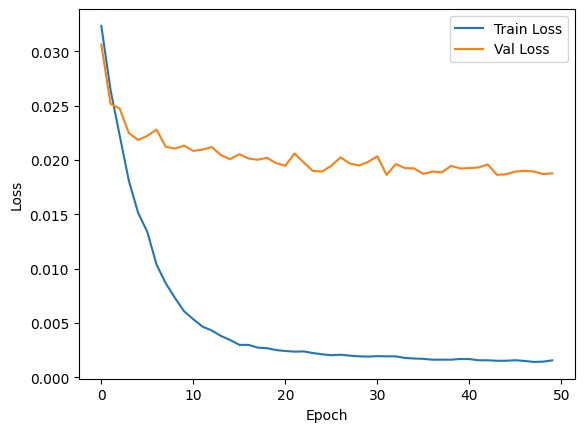

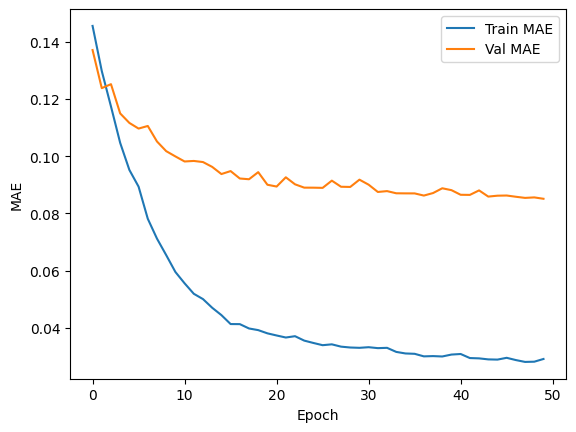

In [42]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [89]:
# Save the entire model
torch.save(model.state_dict(), r'C:\Users\milen\git\ppChem\PPChem_TLC\models\model.pt')

### Parameter Grid Search

In [121]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Initialize the model with Skorch
net = NeuralNetRegressor(
    FCNN,
    module__input_size=X_train.shape[1],
    module__dropout_prob=0.2,
    max_epochs=50,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Define the parameter grid
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs': [20, 50, 100],
    'module__dropout_prob': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128]
}

# Create the grid search object
gs = GridSearchCV(net, param_grid, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform the search
gs.fit(X_train.astype(np.float32), y_train.astype(np.float32))

# Get the best parameters and the corresponding score
print(f"Best parameters found: {gs.best_params_}")
print(f"Best cross-validation score: {-gs.best_score_}")

# Evaluate the best model on the validation set
best_model = gs.best_estimator_
val_predictions = best_model.predict(X_val.astype(np.float32))
val_loss = np.mean((val_predictions - y_val.astype(np.float32)) ** 2)
print(f"Validation Loss: {val_loss}")

# You can also plot training and validation losses if available
train_losses = best_model.history[:, 'train_loss']
valid_losses = best_model.history[:, 'valid_loss']

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# If you also have MAE recorded in the history, you can plot that as well
if 'train_mae' in best_model.history and 'valid_mae' in best_model.history:
    train_maes = best_model.history[:, 'train_mae']
    valid_maes = best_model.history[:, 'valid_mae']

    plt.plot(train_maes, label='Train MAE')
    plt.plot(valid_maes, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits


### Self attention

Epoch 1, Train Loss: 0.03332599144625036, Val Loss: 0.027286925818771124, Train MAE: 0.14665552165947462, Val MAE: 0.1319232058400909
Epoch 2, Train Loss: 0.02483010333227484, Val Loss: 0.030322110668445628, Train MAE: 0.12482269500431262, Val MAE: 0.13528305509438118
Epoch 3, Train Loss: 0.01989441113056321, Val Loss: 0.024020297763248284, Train MAE: 0.1104737987643794, Val MAE: 0.11948245236029227
Epoch 4, Train Loss: 0.015539434875704741, Val Loss: 0.021739627389858168, Train MAE: 0.09624513889613905, Val MAE: 0.11033723906924327
Epoch 5, Train Loss: 0.011319561332072082, Val Loss: 0.021785538798818987, Train MAE: 0.0812455847075111, Val MAE: 0.10673700304081042
Epoch 6, Train Loss: 0.00840150694803972, Val Loss: 0.02174852672033012, Train MAE: 0.0696167749793906, Val MAE: 0.1069038724526763
Epoch 7, Train Loss: 0.006832261800177788, Val Loss: 0.02357565751299262, Train MAE: 0.06286753012161506, Val MAE: 0.10965083353221416
Epoch 8, Train Loss: 0.005617135782775126, Val Loss: 0.0203

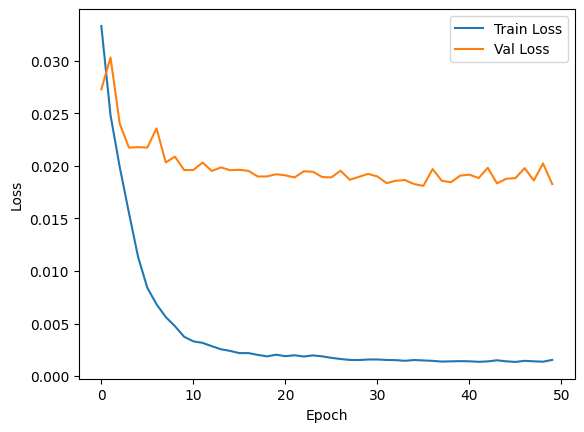

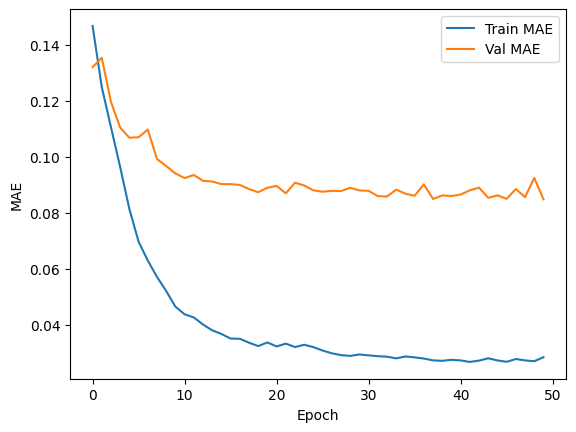

In [54]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
# print(y_val_tensor)

# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

# Initialize the model, loss function, and optimizer
model = FCNN_att(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Hyperparameter tuning for self attention

Epoch 1, Train Loss: 0.04573739286708205, Val Loss: 0.031875602745761476, Train MAE: 0.1691211843176892, Val MAE: 0.14547593394915262
Epoch 2, Train Loss: 0.033064293351612595, Val Loss: 0.03060930680173139, Train MAE: 0.14686618353191175, Val MAE: 0.14027462527155876
Epoch 3, Train Loss: 0.030353412875219397, Val Loss: 0.029159342171624303, Train MAE: 0.14045792755327727, Val MAE: 0.1398562751710415
Epoch 4, Train Loss: 0.02755032107234001, Val Loss: 0.025722428613031905, Train MAE: 0.13270961250129498, Val MAE: 0.1294085377206405
Epoch 5, Train Loss: 0.02471891523976075, Val Loss: 0.02439615735784173, Train MAE: 0.12510133338601967, Val MAE: 0.12410563758263986
Epoch 6, Train Loss: 0.022176059894263744, Val Loss: 0.023550297909726698, Train MAE: 0.1171825846559123, Val MAE: 0.12069059784213702
Epoch 7, Train Loss: 0.02007945558350337, Val Loss: 0.023062780654678743, Train MAE: 0.11090974360704423, Val MAE: 0.11834414582699537
Epoch 8, Train Loss: 0.01835564769020206, Val Loss: 0.0234

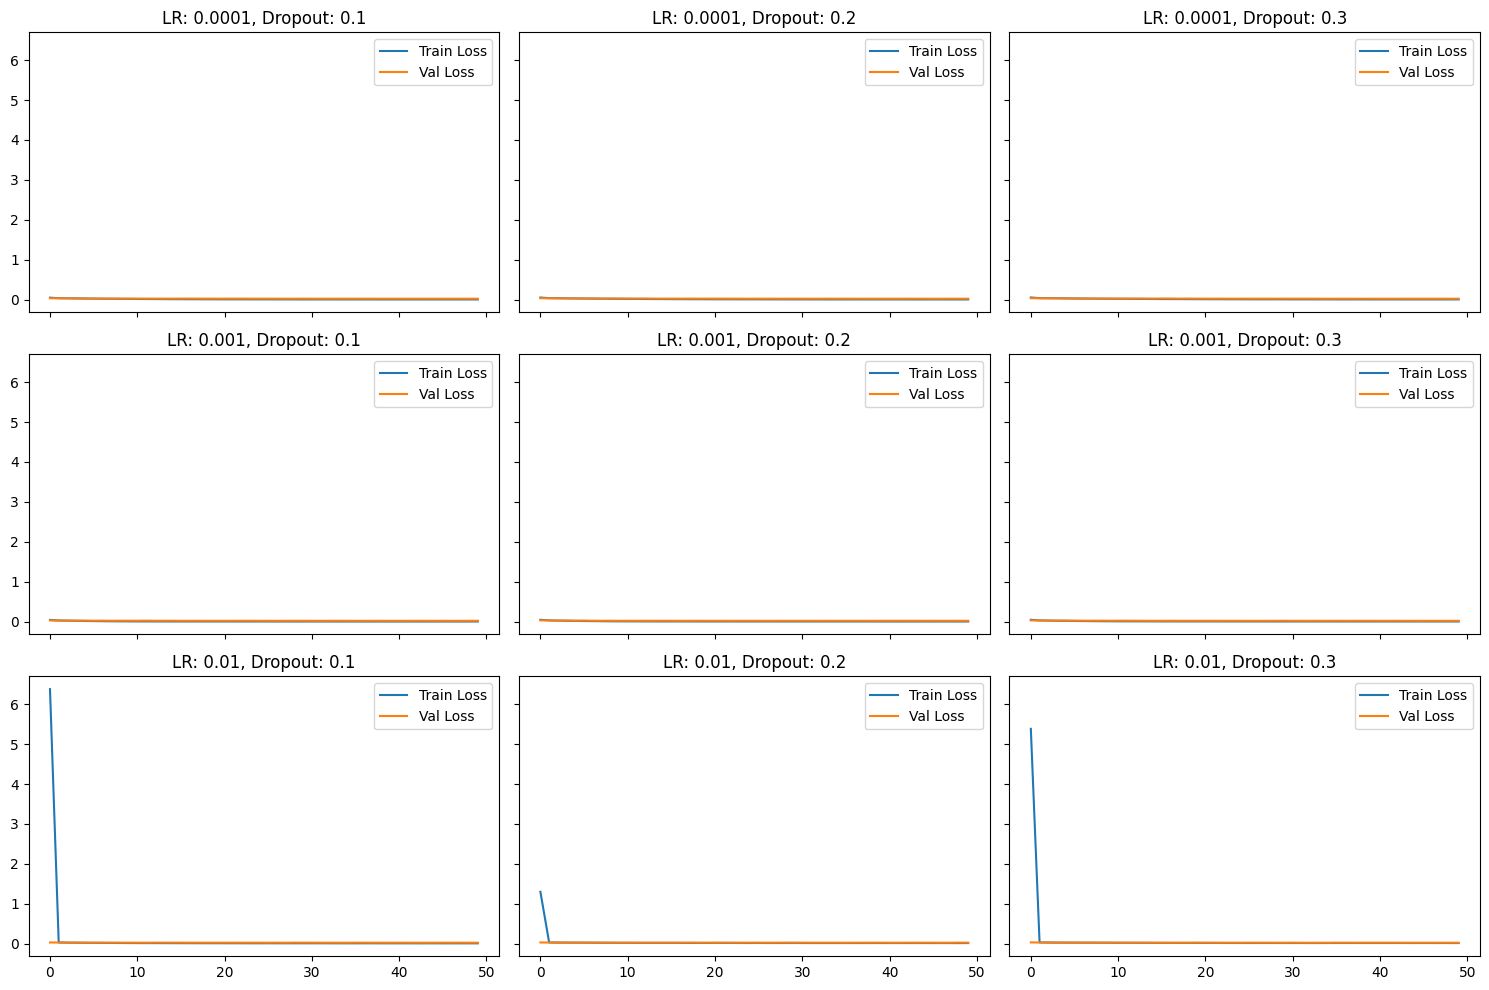

In [46]:
# Hyperparameters to tune
learning_rates = [1e-4, 1e-3, 1e-2]
dropout_probs = [0.1, 0.2, 0.3]
n_epochs = 50

best_val_loss = float('inf')
best_params = None
best_model = None

all_train_losses = {}
all_val_losses = {}

for lr in learning_rates:
    for dropout_prob in dropout_probs:
        model = FCNN_att(input_size=X_train.shape[1], dropout_prob=dropout_prob)
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_losses = []
        val_losses = []
        train_maes = []
        val_maes = []

        for epoch in range(n_epochs):
            train_mae = 0
            val_mae = 0
            model.train()
            train_loss = 0
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                 # Compute MAE
                mae = torch.mean(torch.abs(outputs - labels))
                train_mae += mae.item()

            train_loss /= len(train_dataloader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    # Compute MAE
                    mae = torch.mean(torch.abs(outputs - labels))
                    val_mae += mae.item()

            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)
            train_maes.append(train_mae / len(train_dataloader))
            val_maes.append(val_mae / len(val_dataloader))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = (lr, dropout_prob)
                best_model = model.state_dict()

            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

        all_train_losses[(lr, dropout_prob)] = train_losses
        all_val_losses[(lr, dropout_prob)] = val_losses

print(f'Best params: LR: {best_params[0]}, Dropout: {best_params[1]}, Val Loss: {best_val_loss}')

# Load best model
if best_model:
    model.load_state_dict(best_model)

# Plot training and validation losses for each hyperparameter combination
fig, axes = plt.subplots(len(learning_rates), len(dropout_probs), figsize=(15, 10), sharex=True, sharey=True)

for i, lr in enumerate(learning_rates):
    for j, dropout_prob in enumerate(dropout_probs):
        ax = axes[i, j]
        ax.plot(all_train_losses[(lr, dropout_prob)], label='Train Loss')
        ax.plot(all_val_losses[(lr, dropout_prob)], label='Val Loss')
        ax.set_title(f'LR: {lr}, Dropout: {dropout_prob}')
        ax.legend()

plt.tight_layout()
plt.show()

### ChemBERTA

In [82]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "True"

In [92]:
df = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_cb = df.copy()
df_cb = df_cb[df_cb['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_cb['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [93]:
# Fill missing solvent SMILES with a placeholder (e.g., an empty string)
df_cb['Solvent_A_Smiles'] = df_cb['Solvent_A_Smiles'].fillna('')
df_cb['Solvent_B_Smiles'] = df_cb['Solvent_B_Smiles'].fillna('')

# Create binary indicators for solvent presence
df_cb.loc[:, 'Solvent_A_Present'] = df_cb['Solvent_A_Smiles'].apply(lambda x: 0 if x == '' else 1)
df_cb.loc[:, 'Solvent_B_Present'] = df_cb['Solvent_B_Smiles'].apply(lambda x: 0 if x == '' else 1)

# Extract relevant columns
product_smiles = df_cb['productSmiles_processed'].tolist()
solvent_a_smiles = df_cb['Solvent_A_Smiles'].tolist()
solvent_b_smiles = df_cb['Solvent_B_Smiles'].tolist()
percent_a = df_cb['Percent_A'].values
percent_b = df_cb['Percent_B'].values
solvent_a_present = df_cb['Solvent_A_Present'].values
solvent_b_present = df_cb['Solvent_B_Present'].values
rf_values = df_cb['Rf'].values

In [94]:
# Define the dataset class
class TLC_Dataset(Dataset):
    def __init__(self, product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels):
        self.product_smiles = product_smiles
        self.solvent_a_smiles = solvent_a_smiles
        self.solvent_b_smiles = solvent_b_smiles
        self.numerical_features = numerical_features
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        product_smiles = self.product_smiles[idx]
        solvent_a_smiles = self.solvent_a_smiles[idx]
        solvent_b_smiles = self.solvent_b_smiles[idx]
        numerical_features = self.numerical_features[idx]
        labels = self.labels[idx]
        return product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels

In [95]:
# Combine numerical features
numerical_features = torch.tensor(list(zip(percent_a, percent_b, solvent_a_present, solvent_b_present)), dtype=torch.float32)

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(product_smiles)), test_size=0.2, random_state=42)

# Create training and validation datasets
train_dataset = TLC_Dataset(
    [product_smiles[i] for i in train_indices],
    [solvent_a_smiles[i] for i in train_indices],
    [solvent_b_smiles[i] for i in train_indices],
    numerical_features[train_indices],
    rf_values[train_indices]
)

val_dataset = TLC_Dataset(
    [product_smiles[i] for i in val_indices],
    [solvent_a_smiles[i] for i in val_indices],
    [solvent_b_smiles[i] for i in val_indices],
    numerical_features[val_indices],
    rf_values[val_indices]
)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [96]:
# Initialize the model, loss function, and optimizer
model = FCNNWithChemBERTa(dropout_prob=0.2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features)
        
        # Reshape the target tensor
        labels = labels.view(-1, 1)
            
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Validation loop
    model.eval()
    with torch.no_grad():
        for product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features, labels in val_dataloader:
            outputs = model(product_smiles, solvent_a_smiles, solvent_b_smiles, numerical_features)
            
            # Reshape the target tensor
            labels = labels.view(-1, 1)
            
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyboardInterrupt: 

### FCNN with Rdkit descriptors

In [38]:
# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)

# concatenate all the 2D numpy arrays to a big 2D numpy array
descriptors = np.concatenate([compound_descriptors, solvent_A_descriptors, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(descriptors.shape, type(descriptors), descriptors.ndim, y.ndim, y.shape)

(15062, 14) <class 'numpy.ndarray'> 2 2 (15062, 1)


In [41]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(descriptors, y, test_size=0.2, random_state=42)

Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 500.5640 - mae: 10.1714 - val_loss: 0.3020 - val_mae: 0.4266
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2885 - mae: 0.4007 - val_loss: 0.2303 - val_mae: 0.3762
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1992 - mae: 0.3350 - val_loss: 0.1728 - val_mae: 0.3180
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1597 - mae: 0.3036 - val_loss: 0.1532 - val_mae: 0.3029
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1242 - mae: 0.2719 - val_loss: 0.1177 - val_mae: 0.2705
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1032 - mae: 0.2488 - val_loss: 0.0871 - val_mae: 0.2291
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1010 - mae: 0.2462 - val_loss: 0.0815 - val_mae: 0.2211
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0829 - mae: 0.2257 - val_loss: 0.0764 - val_mae: 0.2146
Epoch 9/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

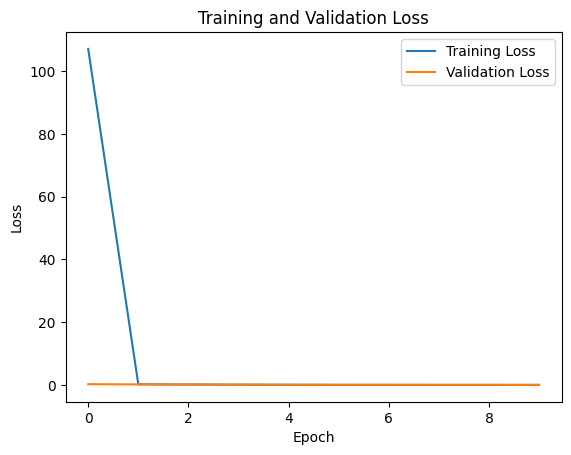

In [44]:
# Create a Sequential model
model = Sequential()

# Define input layer with 14 input features (from shape of X_train)
model.add(Dense(64, activation='relu', input_shape=(14,)))

# Add additional dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer to predict Rf value
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print test loss and mean absolute error
print("Test Loss:", loss)
print("Test MAE:", mae)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### FCNN with Morgan FPs and RDKit Descriptors

In [99]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features_2 = np.concatenate([compound_features, compound_descriptors, solvent_A_features, solvent_A_descriptors, solvent_B_features, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features_2.shape, type(features_2), features_2.ndim, y.ndim, y.shape)

(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2
(15062, 2574) <class 'numpy.ndarray'> 2 2 (15062, 1)


tensor([[0.1800],
        [0.3200],
        [0.5100],
        ...,
        [0.3000],
        [0.5400],
        [0.5500]])
Epoch 1, Train Loss: 0.0334866787887497, Val Loss: 0.030309755904109854, Train MAE: 0.1484186871654159, Val MAE: 0.13959613850242214
Epoch 2, Train Loss: 0.0301870684156723, Val Loss: 0.028147253560784617, Train MAE: 0.14010173222667657, Val MAE: 0.13613415666316686
Epoch 3, Train Loss: 0.027763613514523132, Val Loss: 0.026184466010645818, Train MAE: 0.13363323210484154, Val MAE: 0.1295090657315756
Epoch 4, Train Loss: 0.026023996697457148, Val Loss: 0.025112456504843738, Train MAE: 0.12889466276614672, Val MAE: 0.1253456718827549
Epoch 5, Train Loss: 0.025369872235315075, Val Loss: 0.02446797241113688, Train MAE: 0.1276056990422684, Val MAE: 0.12414444677139583
Epoch 6, Train Loss: 0.02427804760822646, Val Loss: 0.024110551501967406, Train MAE: 0.12376647365504298, Val MAE: 0.12246251239588386
Epoch 7, Train Loss: 0.023196755720682898, Val Loss: 0.02531810904804029

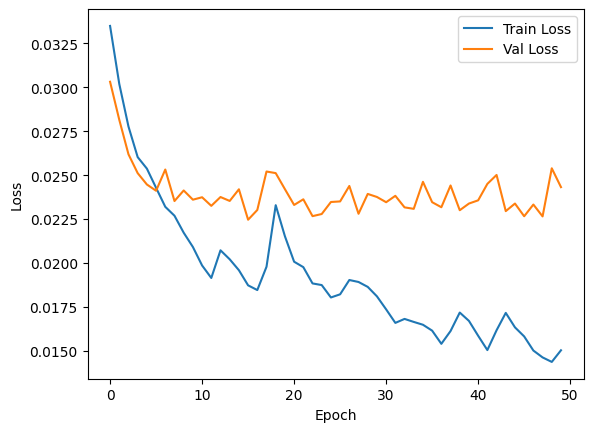

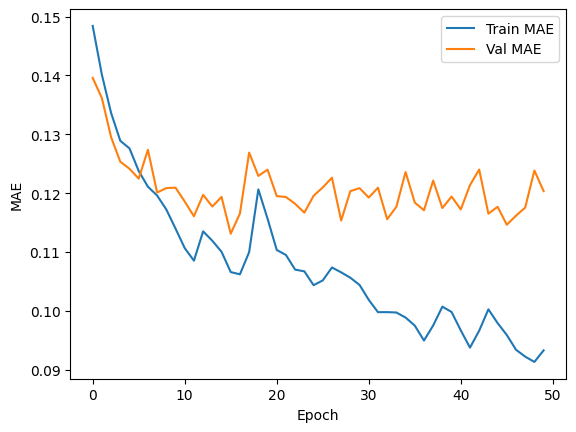

In [113]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features_2, y, test_size=0.2, random_state=42)

# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

print(y_val_tensor)
# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = FCNN_deep(input_size=X_train.shape[1], dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### FCNN with embedded NN

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [115]:
# Encoder for dimensionality reduction
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

# Define the Combined Network class (encoder + decoder)
class CombinedNet(nn.Module):
    def __init__(self, compound_input_dim, solvent_input_dim, embedding_dim, dropout_prob):
        super(CombinedNet, self).__init__()
        self.compound_encoder = Encoder(compound_input_dim, embedding_dim)
        self.solvent_encoder = Encoder(solvent_input_dim, embedding_dim)

        # The input dimension to the final network is the concatenated embeddings + 2 percentages
        combined_input_dim = 3 * embedding_dim + 2

        self.fc1 = nn.Linear(combined_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, compound_fp, solvent_a_fp, solvent_b_fp, percent_a_tensor, percent_b_tensor):
        compound_embedding = self.compound_encoder(compound_fp)
        solvent_a_embedding = self.solvent_encoder(solvent_a_fp)
        solvent_b_embedding = self.solvent_encoder(solvent_b_fp)

        # Concatenate embeddings with percentages
        combined = torch.cat((compound_embedding, solvent_a_embedding, solvent_b_embedding, percent_a_tensor, percent_b_tensor), dim=1)

        x = self.relu(self.fc1(combined))
        x = self.dropout_1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout_2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout_3(x)
        x = self.sigmoid(self.fc4(x))
        return x

In [116]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(f"compound feature shape: {compound_features.shape}, type {type(compound_features)}, dimension {compound_features.ndim}")
print(f"solvent a feature shape: {solvent_A_features.shape}, type {type(solvent_A_features)}, dimension {solvent_A_features.ndim}")

y = np.stack(df_fp['Rf'].values) # I don't know why I called this y, sorry man :D just out of habit I guess. 

(2048,) 1
compound feature shape: (15062, 2048), type <class 'numpy.ndarray'>, dimension 2
solvent a feature shape: (15062, 256), type <class 'numpy.ndarray'>, dimension 2


In [117]:
#Split dataset
X_train_compound, X_test_compound, X_train_solvent_A, X_test_solvent_A, X_train_solvent_B, X_test_solvent_B, X_train_percent_a, X_test_percent_a, X_train_percent_b, X_test_percent_b, y_train, y_test = train_test_split(
compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features, y, test_size=0.2, random_state=42)

In [118]:
# Convert numpy arrays to PyTorch tensors
X_train_compound_tensor = torch.from_numpy(X_train_compound).float()
X_train_solvent_A_tensor = torch.from_numpy(X_train_solvent_A).float()
X_train_solvent_B_tensor = torch.from_numpy(X_train_solvent_B).float()
X_train_percent_a_tensor = torch.from_numpy(X_train_percent_a).float()
X_train_percent_b_tensor = torch.from_numpy(X_train_percent_b).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_compound_tensor = torch.from_numpy(X_test_compound).float()
X_test_solvent_A_tensor = torch.from_numpy(X_test_solvent_A).float()
X_test_solvent_B_tensor = torch.from_numpy(X_test_solvent_B).float()
X_test_percent_a_tensor = torch.from_numpy(X_test_percent_a).float()
X_test_percent_b_tensor = torch.from_numpy(X_test_percent_b).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor)

# Create DataLoaders, define batch size
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1, Train Loss: 0.03168932345533182, Val Loss: 0.025639007333666086, Train MAE: 0.1435253666270347, Val MAE: 0.1278452519327402
Epoch 2, Train Loss: 0.022429949042224694, Val Loss: 0.023209139646496624, Train MAE: 0.1169935512558493, Val MAE: 0.11747780147319038
Epoch 3, Train Loss: 0.01272776064083532, Val Loss: 0.01896004764906441, Train MAE: 0.08471860811508522, Val MAE: 0.09997888701036572
Epoch 4, Train Loss: 0.006965658872600191, Val Loss: 0.01892938625921185, Train MAE: 0.061577881612474954, Val MAE: 0.09463534511936207
Epoch 5, Train Loss: 0.004374703629528759, Val Loss: 0.018004423143186916, Train MAE: 0.0483939327082779, Val MAE: 0.09070129630466302
Epoch 6, Train Loss: 0.0031931475759607066, Val Loss: 0.017102680227253586, Train MAE: 0.04098549134359158, Val MAE: 0.08979107455040018
Epoch 7, Train Loss: 0.0025462705411618113, Val Loss: 0.017643270703653496, Train MAE: 0.03633963309780315, Val MAE: 0.09125830543537934
Epoch 8, Train Loss: 0.0022666253717419094, Val Loss:

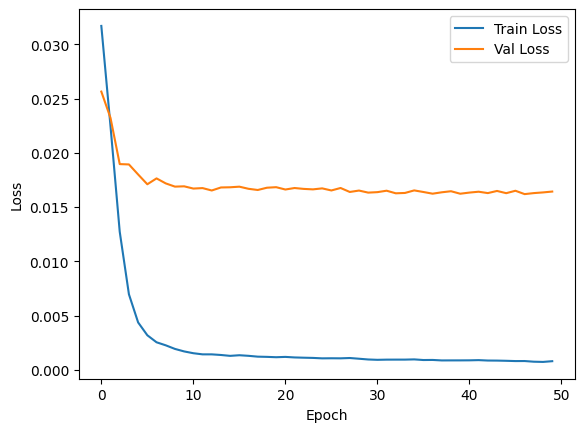

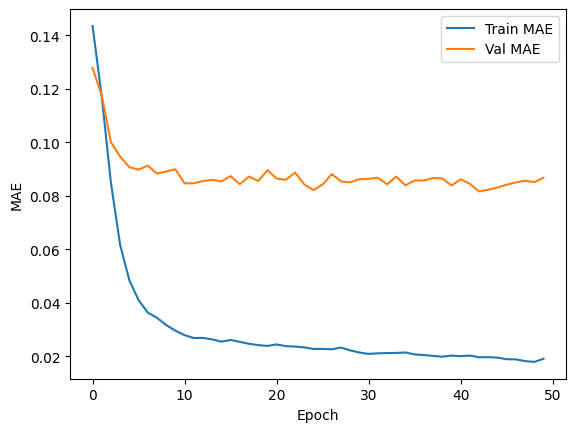

In [119]:
# Initialize the model, loss function, and optimizer
model = CombinedNet(compound_input_dim=2048, solvent_input_dim=256, embedding_dim=128, dropout_prob=0.2)
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor, y_train_tensor in train_dataloader:
        optimizer.zero_grad()
        outputs = model(X_train_compound_tensor, X_train_solvent_A_tensor, X_train_solvent_B_tensor, X_train_percent_a_tensor, X_train_percent_b_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - y_train_tensor))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor, y_test_tensor in val_dataloader:
            outputs = model(X_test_compound_tensor, X_test_solvent_A_tensor, X_test_solvent_B_tensor, X_test_percent_a_tensor, X_test_percent_b_tensor)
            loss = loss_fn(outputs, y_test_tensor)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - y_test_tensor))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## 5.3 RandomForestRegression Model

Import packages for RandomForest Regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor

Preprocess again all the data into a feature matrix (just wanted to try it with another stacking method here)

In [7]:
# Combine all features into a single 2D numpy array
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

y = np.vstack(df_fp['Rf'].values).flatten()  # Flatten to get a 1D array

In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest - Mean Squared Error: 0.015674800020763036
Random Forest - R^2 Score: 0.5332279430548992


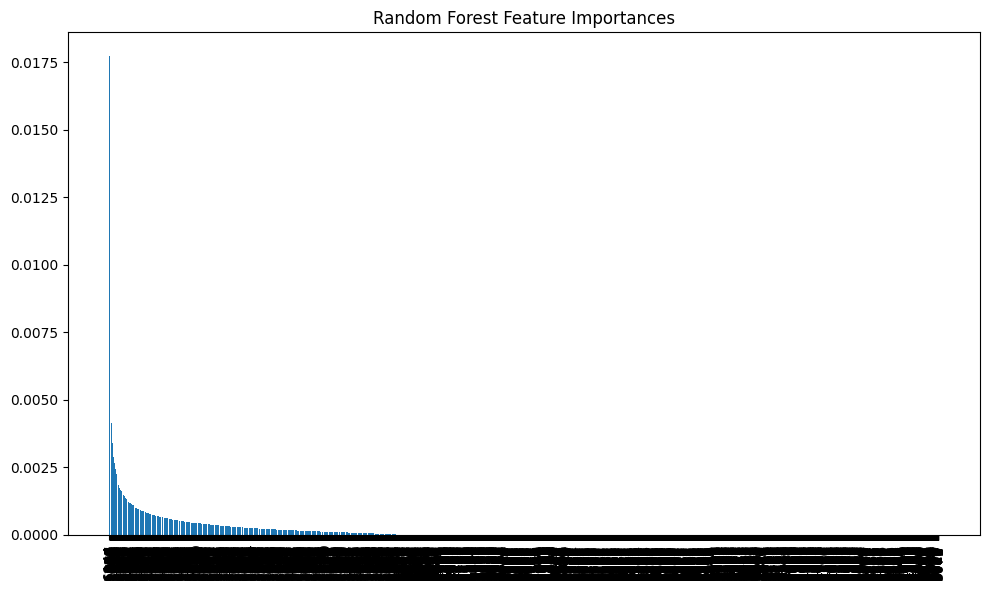

In [9]:
# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

# Feature importance plot
feature_importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), feature_importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), indices_rf, rotation=90)
plt.tight_layout()
plt.show()

## 5.5 GradientBoostingRegressor Model - XGBoost

In [15]:
import xgboost as xgb
import optuna

Use same pre-processing as before.

In [11]:
# Combine all features into a single feature matrix
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

# Prepare the target variable
y = np.vstack(df_fp['Rf'].values).flatten()

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# use optuna for hyperparameter tuning
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-1),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.18191
[1]	validation_0-rmse:0.18076
[2]	validation_0-rmse:0.17948
[3]	validation_0-rmse:0.17865
[4]	validation_0-rmse:0.17759
[5]	validation_0-rmse:0.17688
[6]	validation_0-rmse:0.17607
[7]	validation_0-rmse:0.17530
[8]	validation_0-rmse:0.17471
[9]	validation_0-rmse:0.17412
[10]	validation_0-rmse:0.17357
[11]	validation_0-rmse:0.17321
[12]	validation_0-rmse:0.17268
[13]	validation_0-rmse:0.17202
[14]	validation_0-rmse:0.17149
[15]	validation_0-rmse:0.17098
[16]	validation_0-rmse:0.17073
[17]	validation_0-rmse:0.17042
[18]	validation_0-rmse:0.17003
[19]	validation_0-rmse:0.16966
[20]	validation_0-rmse:0.16929
[21]	validation_0-rmse:0.16903
[22]	validation_0-rmse:0.16872
[23]	validation_0-rmse:0.16841
[24]	validation_0-rmse:0.16800
[25]	validation_0-rmse:0.16773
[26]	validation_0-rmse:0.16748
[27]	validation_0-rmse:0.16723
[28]	validation_0-rmse:0.16702
[29]	validation_0-rmse:0.16691
[30]	validation_0-rmse:0.16670
[31]	validation_0-rmse:0.16644
[32]	validation_0-

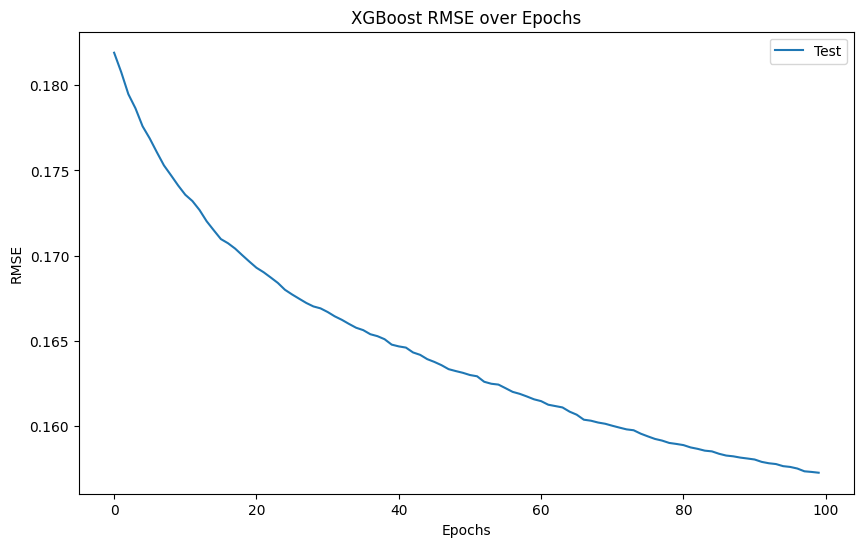

In [13]:
# XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the XGBoost model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

In [18]:
# XGBoost Regressor with Optuna hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print(f"Best hyperparameters: {study.best_params}")

# Train the model with the best hyperparameters
best_params = study.best_params
model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

[I 2024-05-15 10:07:20,555] A new study created in memory with name: no-name-83025231-d2ca-4042-9667-115e8d79978f
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

KeyboardInterrupt: 

## 5.4 Ensemble Learning

### Stacking

In [45]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Initialize base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]

# Train base models
train_meta_features = np.zeros((X_train.shape[0], len(base_models)))
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (name, model) in enumerate(base_models):
    for train_index, val_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        train_meta_features[val_index, i] = model.predict(X_train[val_index])
    model.fit(X_train, y_train)
    test_meta_features[:, i] = model.predict(X_test)

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(train_meta_features, y_train)

# Predict and evaluate
y_pred = meta_model.predict(test_meta_features)
mse = mean_squared_error(y_test, y_pred)
print(f"Stacking - Mean Squared Error: {mse}")

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

### Bagging
(Boostrap Aggregating = training multiple models on different subsets of the data and averaging the predictions)

In [ ]:
from sklearn.ensemble import BaggingRegressor

model_bagging = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=10, random_state=42)
model_bagging.fit(X_train, y_train)
y_pred_bagging = model_bagging.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Bagging - Mean Squared Error: {mse_bagging}")

### Hybrid Models

NN embeddings as input features to Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Train Embedding Neural Network
embedding_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Adjust embedding size as needed
])
embedding_model.compile(optimizer='adam', loss='mean_squared_error')
embedding_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Generate Embeddings
X_train_embeddings = embedding_model.predict(X_train)
X_test_embeddings = embedding_model.predict(X_test)

# Train Random Forest Model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_embeddings, y_train)

# Train XGBoost Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train_embeddings, y_train, eval_set=[(X_test_embeddings, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Generate Predictions
y_pred_rf = model_rf.predict(X_test_embeddings)
y_pred_xgb = model_xgb.predict(X_test_embeddings)

# Evaluate Hybrid Model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.0736 - val_loss: 0.0334
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0280 - val_loss: 0.0276
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0251 - val_loss: 0.0265
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0225 - val_loss: 0.0252
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0188 - val_loss: 0.0242
Epoch 9/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0168 - val_loss: 0.0219
Epoch 10/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0146 - val_loss: 0.0216
Epoch 11/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0147 - val_loss: 0.0223
Epoch 12/50
302/302 ━━━━━━━━━━

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Random Forest - Mean Squared Error: 0.019957787098663894
Random Forest - R^2 Score: 0.4056870056539159
XGBoost - Mean Squared Error: 0.018870959633685132
XGBoost - R^2 Score: 0.4380510990203761
